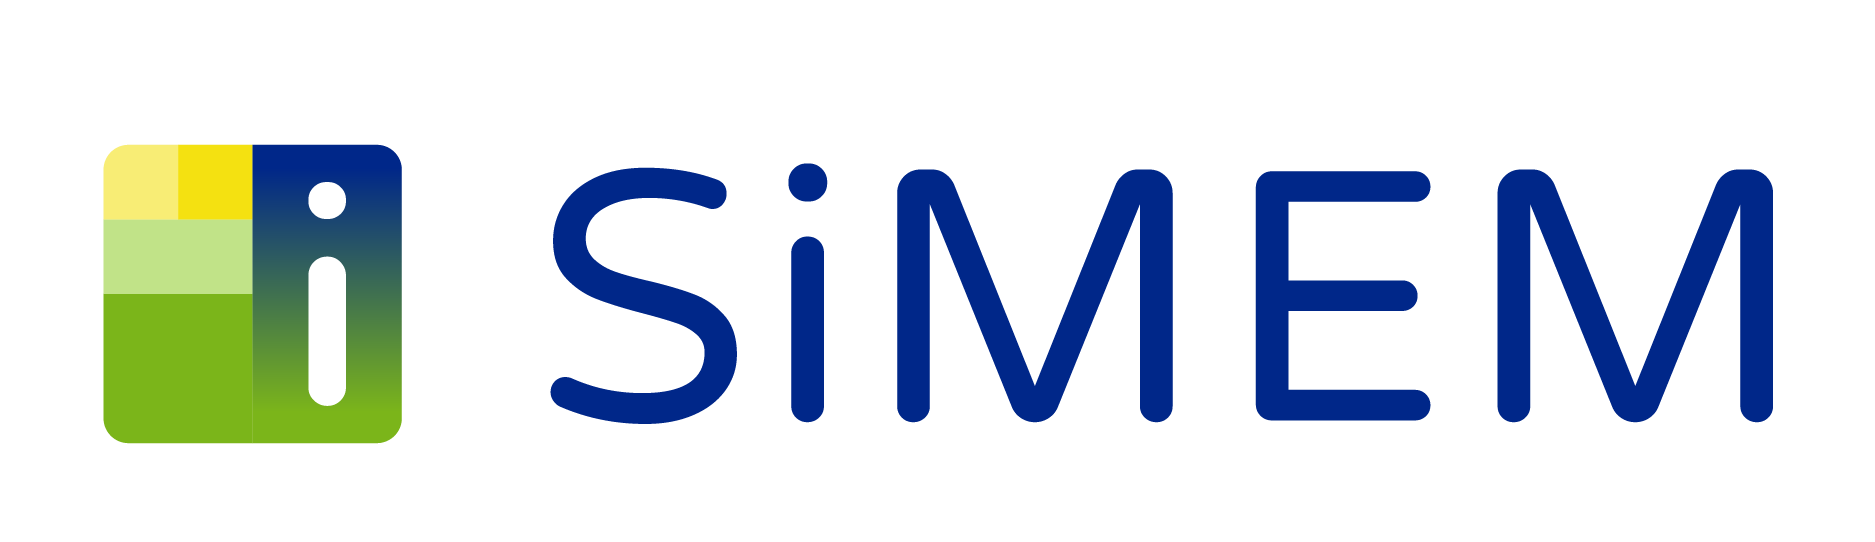

[SiMEM](https://www.simem.co/)

## Objetivos de este Notebook

* Explicar cómo se puede consultar el inventario de variables que se publican en SiMEM.
* Explicar cómo encontrar y consultar el conjunto de datos que contiene cierta variable de interés.
* Procesar el conjunto de datos para obtener la serie de tiempo de una variable en un rango de fecha especificado.
* Graficar la serie de tiempo de la variable.

### Carga del simem

En la siguiente celda se importa el objeto ReadSIMEM, que contiene el método para consultar los conjuntos de datos de SIMEM.

In [3]:
import sys
import os
# !{sys.executable} -m pip install pydataxm
from pydataxm.pydatasimem import ReadSIMEM, CatalogSIMEM

### Definición de parámetros de interés

Se define la variable a la cuál se le desea conocer su serie de tiempo, así como los rangos de fecha para ello

In [4]:
variable = 'RRI'
fecha_inicio ='2023-01-01'
fecha_fin = '2023-12-31'

### Consultar el inventario de variables

En la siguiente celda se muestra cómo consultar el inventario de variables de SiMEM con el objeto PyDataSimem, teniendo como parámetro importante su repectivo id

In [5]:
inventario_variables = CatalogSIMEM('Variables')
df_inventario_variables = inventario_variables.get_data()
df_inventario_variables.head()

,idDataset,nombreDataset,codigoVariable,nombreVariable,descripcion,unidadMedida,fechaPublicacion,fechaInicio,fechaFin
0,71a7b9,Niveles Mínimos Operativos de Embalses de invi...,MinimoOperativo,Mínimo Operativo,Valor de los niveles mensuales de embalses par...,kWh,2023-11-01T17:02:30.843,2022-01-01T00:00:00,None
1,bd583d,Niveles Mínimos Operativos de Embalses de verano,MinimoOperativo,Mínimo Operativo,Valor de los niveles mensuales de embalses par...,kWh,2023-11-01T17:02:30.843,2022-01-01T00:00:00,None
2,e427a2,Precio oferta arranque y parada por unidad par...,PrecioOfertaArranqueParadaUSD,Precio oferta arranque y parada en dólares,Precio oferta arranque y parada por unidad par...,USD,2023-09-12T15:30:25.253,2022-01-01T00:00:00,None
3,86d298,Proyecciones de energía de los contratos no re...,EnergiaPromedio,Promedio de las cantidades de los contratos,Se calcula el promedio de las cantidades de en...,GWh/mes,2023-11-28T14:51:00.693,2022-01-01T00:00:00,None
4,15df39,Proyecciones de energía de los contratos no re...,EnergiaPromedio,Promedio de las cantidades de los contratos,Se calcula el promedio de las cantidades de en...,GWh/mes,2023-11-28T14:51:00.693,2022-01-01T00:00:00,None


Una vez obtenido el inventario de variables, se busca el conjunto de datos que contiene la variable de interés y se obtiene su id. También se extrae la unidad de medida de la variable en cuestión. Es importante tener en cuenta que algunas variables pueden hallarse en varios conjuntos de datos, para efectos del ejemplo se escoge una variable que se encuentra únicamente en un conjunto de datos de SiMEM

In [9]:
id_dataset = df_inventario_variables.query('codigoVariable==@variable')['idDataset'].iloc[0]
print('IdDataset:', id_dataset)
unidad_medida = df_inventario_variables.query('codigoVariable==@variable')['unidadMedida'].iloc[0]
print('Unidad de medida:',unidad_medida)

IdDataset: 6dc639
Unidad de medida: COP


### Consultar el conjunto de datos que contiene la variable

A continuación se consulta el conjunto de datos en el rango de fecha especificado inicialmente; además, se consulta la columna de fecha principal del conjunto de datos mediante el método *get_filter_date*, columna que será importante para hacer la serie de tiempo de la variable.

In [13]:
dataset = ReadSIMEM(id_dataset, fecha_inicio, fecha_fin)
df_dataset = dataset.main()
columna_fecha_principal = "FechaInicio"
df_dataset.head()

,CodigoVariable,FechaInicio,CodigoDuracion,UnidadMedida,CodigoPlanta,Version,Valor
0,OEFDiaria,2023-01-31,P1D,kWh,3C4V,TX6,0.00
1,OEFDiaria,2023-01-31,P1D,kWh,HMLG,TX6,2389013.69
2,OEFDiaria,2023-01-31,P1D,kWh,PRC2,TX6,3398605.08
3,OEFDiaria,2023-01-31,P1D,kWh,LMR1,TX6,0.00
4,OEFDiaria,2023-01-31,P1D,kWh,JBV1,TX6,0.00


Ahora es necesario procesar la información para obtener la serie de tiempo de la variable, para esto existen dos posibilidades:

* La variable se encuentra dentro de la columna CodigoVariable del conjunto de dato. En este caso, se buscan los registros que tengan la variable de interés en la columna CodigoVariable, se agrupa por fecha, variable y se agrega la columna Valor. Es importante verificar que los valores de la variable si estén en la columna Valor, de lo contrario ajustarla en el parámetro *columna_valor* de la celda de abajo.

* La variable es una de las columnas del conjunto de datos. En este caso, se agrupa directamente por fecha y se agrega la columna de la variable en una columna que se denomina Valor

Finalmente, se obtiene la serie de tiempo de la variable en el DataFrame *df_final*

In [14]:
if 'CodigoVariable' in df_dataset.columns.values:
    columna_valor = 'Valor'
    df_final = df_dataset.query("CodigoVariable==@variable")[[columna_fecha_principal, 'CodigoVariable', columna_valor]].groupby([columna_fecha_principal, 'CodigoVariable']).agg(Valor=(columna_valor,'sum')).reset_index()
elif variable in df_dataset.columns.values:
    df_final = df_dataset[[columna_fecha_principal,variable]].groupby(columna_fecha_principal).agg(Valor=(variable,'sum')).reset_index()

### Graficar la serie de tiempo

Se hace la gráfica de la serie de tiempo de la variable con plotly.

In [15]:
import plotly.graph_objects as go
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x=df_final[columna_fecha_principal], y=df_final['Valor'], mode='lines'))
fig = fig.update_layout(title='Gráfico de Serie de Tiempo', xaxis_title='Fecha', yaxis_title=f'{variable} [{unidad_medida}]', yaxis=dict(showexponent='all', exponentformat='e'), xaxis=dict(showspikes=True, tickformat="%Y-%m-%d"), hovermode="x")
fig.show()